In [1]:
# this config file sits in the same folder as the current notebook
# it contains the configuration for this experiment
#from configuration import config, rr_IF, rr_LO, IQ_imbalance
#from configuration import
#import importlib
#importlib.reload(configuration)
# to import files from parent directory
#import sys
#sys.path.insert(0, '../LabControl')

In [2]:
from configuration import *
import importlib
#importlib.reload(configuration) ### can someone fiture out why it doesn't let me do it? 

In [1]:
import sys
sys.path.insert(0, '../LabControl')

import matplotlib.pyplot as plt

from Instruments.SA124B.SA124B import SA124B

from qm.QuantumMachinesManager import QuantumMachinesManager
#from qm.qua import program, infinite_loop_, play
from qm.qua import *

ModuleNotFoundError: No module named 'Instruments'

In [4]:
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

2021-03-12 19:04:31,795 - qm - INFO - Performing health check
2021-03-12 19:04:31,801 - qm - INFO - Health check passed


In [ ]:
config['elements']['rr']['time_of_flight']
readout_len
rr_mixer_gain
config['waveforms']['readout_wf']['sample']

In [5]:
# We have tuned the IQ mixer according to the tutorial-2-2-SA124B-MixerTuning.ipynb document.
# These are key numbers obtained:
dcOffsetI =  0.010937499999999989
dcOffsetQ = -0.007500000000000003
mixerGainCorrection = 0.011632291769074063
mixerPhaseCorrection = -0.03598680846432449
# after this step we have tuned the IQ mixer.
qm.set_output_dc_offset_by_element("rr", "I", float(dcOffsetI)) 
qm.set_output_dc_offset_by_element("rr", "Q", float(dcOffsetQ))
qm.set_mixer_correction("mixer_rr", rr_IF, rr_LO, IQ_imbalance(mixerGainCorrection, mixerPhaseCorrection))

In [6]:
with program() as cw:
    with infinite_loop_():
        play("CW", "rr")
job = qm.execute(cw)

2021-03-12 19:04:38,736 - qm - INFO - Flags: 
2021-03-12 19:04:38,736 - qm - INFO - Executing high level program


@SA124B.initSweep: resolution= 250000.0


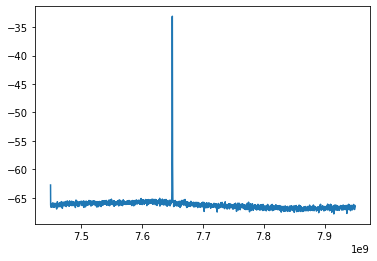

In [7]:
# check spectrum for debugging purposes
# first, check the spectrum of IQ mixer's RF output, to see if you only see the desired LO frequency +/- sideband.
# then, check the spectrum of image rejection mixer's IF output, to see if you only see the desired sideband.
sa124B = SA124B(serialNumber = 19184645, mode = 'sweep')

freqs, amps = sa124B.initSweep(7.7e9, 0.5e9, 1000, 0)

plt.figure()
plt.plot(freqs, amps)

In [8]:
sa124B.stop()
job.halt()

True

In [ ]:
with program() as tof_cal:

    adc_st = declare_stream(adc_trace=True)
    n = declare(int)
    
    with for_(n, 0, n < 1000, n + 1):
        reset_phase("rr")
        measure("long_readout", "rr", adc_st)
        wait(100, "rr")
    
    with stream_processing(): 
        adc_st.input1().average().save('adc_mem')
        adc_st.input1().average().fft().save('adc_fft')

In [ ]:
job2 = qm.execute(tof_cal)

In [ ]:
res_handles = job2.result_handles
adc_handle = res_handles.get('adc_mem')
plt.plot(adc_handle.fetch_all() /2**12)
job2.halt()

In [ ]:
adc_fft_handle = res_handles.get('adc_fft')
#plt.plot(adc_fft_handle.fetch_all()[10:])

fft_data = adc_fft_handle.fetch_all()
fft_data = np.sqrt(np.sum(np.squeeze(fft_data) ** 2, axis=1)) / long_redout_len
plt.plot(
    np.arange(0, 0.5, 1 / long_redout_len)[5:], fft_data[5: int(np.ceil(long_redout_len / 2))]
)

In [ ]:
import numpy as np
f_start = -30e6
f_final = -70e6
df = -0.1e6
f_vec = np.arange(f_start, f_final, df)

with program() as rr_spec:
    
    n = declare(int)
    f = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    
    with for_(n, 0, n<5000, n+1):
        with for_(f, f_start, f>f_final, f+df):
            update_frequency("rr", f)
            #measure("readout", "rr", None, demod.full('integW1', I), demod.full('integW2', Q))
            measure("long_readout", "rr", None, demod.full('long_integW1', I), demod.full('long_integW2', Q))
            wait(100, "rr")
            save(I, I_st)
            save(Q, Q_st)
            
    with stream_processing():
        I_st.buffer(len(f_vec)).average().save('I_mem')
        Q_st.buffer(len(f_vec)).average().save('Q_mem') 

In [ ]:
job = qm.execute(rr_spec)

In [ ]:
res_handles = job.result_handles
res_handles.wait_for_all_values()
I_handle = res_handles.get('I_mem')
Q_handle = res_handles.get('Q_mem')
c = I_handle.fetch_all() + 1j*Q_handle.fetch_all()

plt.plot(f_vec/1e6, np.abs(c))